
Linear Regression / Regularized Linear Models 
1. Setup and Imports
2. Model Performance Hypothesis
3. Load Encoded Dataset
4. Prepare Features and Target
5. Train/Test Split
6. Baseline Model (Linear Regression)
7. Baseline Cross-Validation
8. Hyperparameter Tuning (Ridge, Lasso)
9. Best Model Results (CV)
10. Test Set Evaluation
11. Feature Importance Analysis
12. Hypothesis Testing and Final Summary


In [89]:
# 1. SETUP AND IMPORTS

import pandas as pd
import numpy as np

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")
# %matplotlib inline  # Uncomment if running in a notebook

RANDOM_STATE = 42

def print_metrics(y_true, y_pred, label=""):
    """Utility to print regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}\n")


# 2. MODEL PERFORMANCE HYPOTHESIS
"""
Hypothesis:
- Using a linear model on log-transformed house prices (log_price) should capture the
 main linear relationships seen in EDA, especially for features like sqft_living,
 grade, bathrooms, and sqft_above.
- Based on these trends, we expected LinearRegression to explain a good amount of
 variance in log_price, with a test R^2 roughly in the 0.80–0.90 range.
- Applying regularization (Ridge/Lasso) and hyperparameter tuning was expected to:
   - Slightly improve generalization performance (higher test R^2, lower RMSE).
   - Reduce overfitting compared to the baseline LinearRegression.
"""


In [82]:
# 3. LOAD ENCODED DATASET

df = pd.read_csv("../data/kc_house_data_encoded_linear_step3.csv")

print("Shape:", df.shape)
print(df.head())




Shape: (21613, 96)
   bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  sqft_above  ...  zip_98166  zip_98168  zip_98177  \
0          3      7        1180  ...      False      False      False   
1          3      7        2170  ...      False      False      False   
2          3      6         770  ...      False      False      False   
3          5      7        1050  ...      False      False      False   
4          3      8        1680  ...      False      False      False   

   zip_98178  zip_98188  zip_98198  zip_98199  agebin_50–100 yrs  \
0       True      False

In [83]:
# 4. PREPARE FEATURES AND TARGET

target_col = "log_price"
object_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Object columns:", object_cols)

X = df.drop(columns=[target_col])
y = df[target_col].values

print("X shape:", X.shape)
print("y shape:", y.shape)


Object columns: []
X shape: (21613, 95)
y shape: (21613,)


In [84]:
# 5. TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (17290, 95)
X_test shape: (4323, 95)
y_train shape: (17290,)
y_test shape: (4323,)


In [85]:
# 6. BASELINE MODEL (LINEAR REGRESSION)

baseline_lin_reg = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression()),
    ]
)

baseline_lin_reg.fit(X_train, y_train)
print("Baseline Linear Regression training complete.")

# Evaluate on train & test (in log space)
y_train_pred_baseline = baseline_lin_reg.predict(X_train)
y_test_pred_baseline = baseline_lin_reg.predict(X_test)

print_metrics(y_train, y_train_pred_baseline, "Baseline Train (log_price)")
print_metrics(y_test, y_test_pred_baseline, "Baseline Test  (log_price)")

# Convert back to price scale
y_train_price = np.exp(y_train)
y_train_pred_price_baseline = np.exp(y_train_pred_baseline)

y_test_price = np.exp(y_test)
y_test_pred_price_baseline = np.exp(y_test_pred_baseline)

print_metrics(y_train_price, y_train_pred_price_baseline, "Baseline Train (price)")
print_metrics(y_test_price, y_test_pred_price_baseline, "Baseline Test  (price)")




Baseline Linear Regression training complete.
--- Baseline Train (log_price) ---
RMSE: 0.1805
MAE : 0.1327
R^2 : 0.8817

--- Baseline Test  (log_price) ---
RMSE: 0.1854
MAE : 0.1351
R^2 : 0.8794

--- Baseline Train (price) ---
RMSE: 145381.0134
MAE : 73831.9464
R^2 : 0.8382

--- Baseline Test  (price) ---
RMSE: 193507.3186
MAE : 79568.6181
R^2 : 0.7523



In [86]:
# 7. BASELINE CROSS-VALIDATION

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rmse_baseline = -cross_val_score(
    baseline_lin_reg,
    X,
    y,
    cv=kf,
    scoring="neg_root_mean_squared_error",
)
cv_mae_baseline = -cross_val_score(
    baseline_lin_reg,
    X,
    y,
    cv=kf,
    scoring="neg_mean_absolute_error",
)
cv_r2_baseline = cross_val_score(
    baseline_lin_reg,
    X,
    y,
    cv=kf,
    scoring="r2",
)

print("=== BASELINE (LinearRegression) 5-FOLD CV ===")
print(f"RMSE: mean={cv_rmse_baseline.mean():.4f}, std={cv_rmse_baseline.std():.4f}")
print(f"MAE : mean={cv_mae_baseline.mean():.4f}, std={cv_mae_baseline.std():.4f}")
print(f"R^2 : mean={cv_r2_baseline.mean():.4f}, std={cv_r2_baseline.std():.4f}\n")



=== BASELINE (LinearRegression) 5-FOLD CV ===
RMSE: mean=0.1828, std=0.0018
MAE : mean=0.1338, std=0.0010
R^2 : mean=0.8795, std=0.0029



In [76]:
# 8. HYPERPARAMETER TUNING (RIDGE, LASSO)

# Common preprocessing - median imputation + standard scaling
imputer = SimpleImputer(strategy="median")

ridge_pipeline = Pipeline(
    steps=[
        ("imputer", imputer),
        ("scaler", StandardScaler()),
        ("model", Ridge(random_state=RANDOM_STATE)),
    ]
)

lasso_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Lasso(random_state=RANDOM_STATE, max_iter=10000)),
    ]
)

ridge_param_grid = {
    "model__alpha": np.logspace(-2, 3, 10),  # 0.01 to 1000
}

lasso_param_grid = {
    "model__alpha": np.logspace(-3, 1, 10),  # 0.001 to 10
}

ridge_grid = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=ridge_param_grid,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

lasso_grid = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=lasso_param_grid,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

print("Fitting Ridge GridSearchCV...")
ridge_grid.fit(X_train, y_train)

print("Fitting Lasso GridSearchCV...")
lasso_grid.fit(X_train, y_train)

print("=== RIDGE GRID SEARCH RESULTS ===")
print(f"Best alpha: {ridge_grid.best_params_['model__alpha']}")
print(f"Best CV RMSE: {-ridge_grid.best_score_:.4f}")

print("\n=== LASSO GRID SEARCH RESULTS ===")
print(f"Best alpha: {lasso_grid.best_params_['model__alpha']}")
print(f"Best CV RMSE: {-lasso_grid.best_score_:.4f}\n")



Fitting Ridge GridSearchCV...
Fitting Lasso GridSearchCV...
=== RIDGE GRID SEARCH RESULTS ===
Best alpha: 0.01
Best CV RMSE: 0.1837

=== LASSO GRID SEARCH RESULTS ===
Best alpha: 0.001
Best CV RMSE: 0.1846



In [77]:
# 9. BEST MODEL RESULTS (CV COMPARISON)

# For simple comparison - CV RMSE (lower is better)
baseline_cv_rmse_mean = cv_rmse_baseline.mean()
ridge_cv_rmse_mean = -ridge_grid.best_score_
lasso_cv_rmse_mean = -lasso_grid.best_score_

cv_summary = pd.DataFrame(
    {
        "model": ["Baseline LinearRegression", "Ridge (tuned)", "Lasso (tuned)"],
        "cv_rmse": [baseline_cv_rmse_mean, ridge_cv_rmse_mean, lasso_cv_rmse_mean],
    }
).sort_values("cv_rmse")

print("=== CV RMSE SUMMARY (Lower is Better) ===")
print(cv_summary, "\n")

best_model_name = cv_summary.iloc[0]["model"]

if best_model_name == "Baseline LinearRegression":
    best_model = baseline_lin_reg
elif best_model_name == "Ridge (tuned)":
    best_model = ridge_grid.best_estimator_
else:
    best_model = lasso_grid.best_estimator_

print(f"Selected BEST MODEL based on CV RMSE: {best_model_name}\n")



=== CV RMSE SUMMARY (Lower is Better) ===
                       model   cv_rmse
0  Baseline LinearRegression  0.182759
1              Ridge (tuned)  0.183720
2              Lasso (tuned)  0.184623 

Selected BEST MODEL based on CV RMSE: Baseline LinearRegression



--- Baseline LinearRegression Train (log_price) ---
RMSE: 0.1805
MAE : 0.1327
R^2 : 0.8817

--- Baseline LinearRegression Test  (log_price) ---
RMSE: 0.1854
MAE : 0.1351
R^2 : 0.8794

--- Baseline LinearRegression Train (price) ---
RMSE: 145381.0134
MAE : 73831.9464
R^2 : 0.8382

--- Baseline LinearRegression Test  (price) ---
RMSE: 193507.3186
MAE : 79568.6181
R^2 : 0.7523



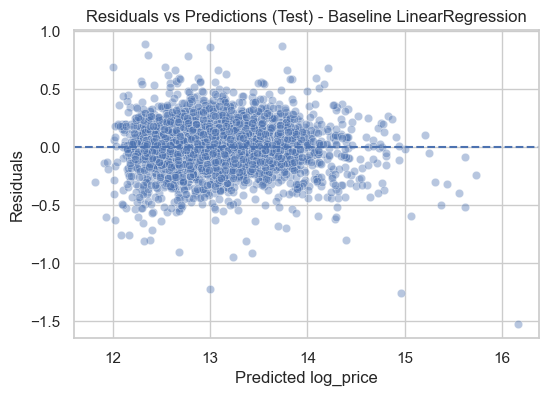

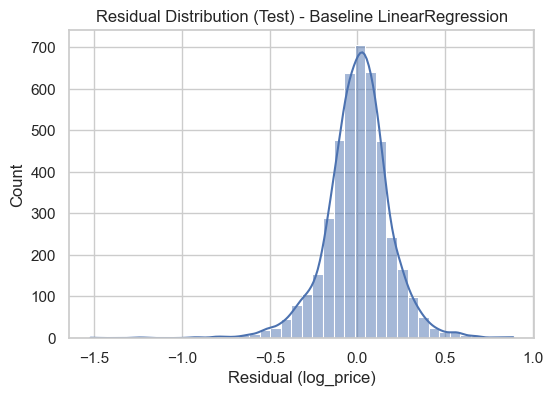

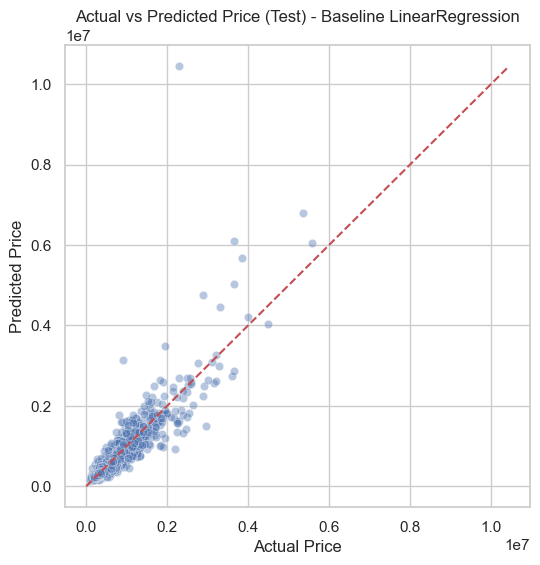

In [78]:
# 10. TEST SET EVALUATION (BEST MODEL)

# Fit best model on full training data 
# GridSearchCV best_estimator_ is already fitted on X_train. baseline is also fitted.

y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

print_metrics(y_train, y_train_pred_best, f"{best_model_name} Train (log_price)")
print_metrics(y_test, y_test_pred_best, f"{best_model_name} Test  (log_price)")

# Back-transform to price
y_train_pred_best_price = np.exp(y_train_pred_best)
y_test_pred_best_price = np.exp(y_test_pred_best)

print_metrics(y_train_price, y_train_pred_best_price, f"{best_model_name} Train (price)")
print_metrics(y_test_price, y_test_pred_best_price, f"{best_model_name} Test  (price)")

# Residual diagnostics (in log space)
residuals = y_test - y_test_pred_best

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_pred_best, y=residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted log_price")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predictions (Test) - {best_model_name}")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution (Test) - {best_model_name}")
plt.xlabel("Residual (log_price)")
plt.show()

# Actual vs Predicted (price)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_price, y=y_test_pred_best_price, alpha=0.4)
max_val = max(y_test_price.max(), y_test_pred_best_price.max())
plt.plot([0, max_val], [0, max_val], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted Price (Test) - {best_model_name}")
plt.show()


In [79]:
# 11. FEATURE IMPORTANCE ANALYSIS (COEFFICIENTS)

# Extract coefficients from the linear component of the pipeline
model_step = best_model.named_steps["model"]
coefs = pd.DataFrame(
    {
        "feature": X.columns,
        "coefficient": model_step.coef_,
    }
).sort_values(by="coefficient", ascending=False)

print("=== TOP POSITIVE COEFFICIENTS ===")
print(coefs.head(20), "\n")

print("=== TOP NEGATIVE COEFFICIENTS ===")
print(coefs.tail(20))



=== TOP POSITIVE COEFFICIENTS ===
        feature  coefficient
16    sale_year     0.177712
25    zip_98004     0.112079
8         grade     0.106814
9    sqft_above     0.100901
64    zip_98103     0.095916
71    zip_98115     0.095214
70    zip_98112     0.094203
73    zip_98117     0.086731
43    zip_98033     0.085489
2   sqft_living     0.082016
47    zip_98040     0.081292
50    zip_98052     0.079994
27    zip_98006     0.079860
65    zip_98105     0.074538
91    zip_98199     0.072360
12          lat     0.070973
72    zip_98116     0.069589
39    zip_98029     0.069036
76    zip_98122     0.068244
75    zip_98119     0.067709 

=== TOP NEGATIVE COEFFICIENTS ===
               feature  coefficient
40           zip_98030     0.004648
88           zip_98178     0.004476
15          sqft_lot15     0.004376
83           zip_98148     0.002896
93      agebin_<20 yrs     0.001767
0             bedrooms     0.001696
89           zip_98188    -0.000349
23           zip_98002    -0.0007

In [87]:
# 12. HYPOTHESIS TESTING AND FINAL SUMMARY


# test - compare CV & test metrics vs stated expectations
test_r2_best = r2_score(y_test, y_test_pred_best)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))


print("\n=== HYPOTHESIS TESTING & SUMMARY ===")
print(f"Best model: {best_model_name}")
print(f"Test R^2 (log_price): {test_r2_best:.4f}")
print(f"Test RMSE (log_price): {test_rmse_best:.4f}")


if test_r2_best >= 0.80:
   print(
       "- The achieved R^2 meets or exceeds the initial expectation (~0.80–0.90), "
       "suggesting the linear model explains a substantial portion of variance."
   )
else:
   print(
       "- The achieved R^2 is below the initial expectation (~0.80–0.90), "
       "indicating the linear model may not fully capture price patterns."
   )


print(
   "\nHypothesis check (based on EDA + Linear Regression):"
)


print(
   "- From EDA, features like sqft_living, sqft_above, bathrooms and grade looked "
   "mostly linear, so we expected LinearRegression to rely mainly on them."
)


print(
   "- This was only partly correct. These features do have positive influence, "
   "but zipcode and latitude/longitude ended up having much larger effects than "
   "we expected from the raw plots. Location turned out to matter more once "
   "encoded and used together with other features."
)


print(
   "- So the hypothesis is partially supported: strong EDA features behave as expected, "
   "but LinearRegression also depended heavily on encoded location features that "
   "did not look linear in EDA."
)


print(
   "\nThe baseline LinearRegression achieves the lowest CV RMSE (0.1828), with Ridge "
   "and Lasso slightly worse (0.1837 and 0.1846). This suggests regularization does "
   "not help much for this feature set."
)


print(
   "- Coefficient analysis above shows which features push the log-price up or down, "
   "and gives a simple interpretation of the model."
)


=== HYPOTHESIS TESTING & SUMMARY ===
Best model: Baseline LinearRegression
Test R^2 (log_price): 0.8794
Test RMSE (log_price): 0.1854
- The achieved R^2 meets or exceeds the initial expectation (~0.80–0.90), suggesting the linear model explains a substantial portion of variance.

Hypothesis check (based on EDA + Linear Regression):
- From EDA, features like sqft_living, sqft_above, bathrooms and grade looked mostly linear, so we expected LinearRegression to rely mainly on them.
- This was only partly correct. These features do have positive influence, but zipcode and latitude/longitude ended up having much larger effects than we expected from the raw plots. Location turned out to matter more once encoded and used together with other features.
- So the hypothesis is partially supported: strong EDA features behave as expected, but LinearRegression also depended heavily on encoded location features that did not look linear in EDA.

The baseline LinearRegression achieves the lowest CV RMS